In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = "32"
from IPython.display import clear_output

# this code simulations the 3srw with trapping

In [44]:
def walkit(k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5):
    """
    kap is the trapping rate from rest
    k1 is the inverse mean resting time
    k2 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta1 is the probability of starting at rest
    theta2 is the probability of starting in motion
    """
    if theta1+theta2!=1.0:
        raise Exception('Initial conditions do not sum to 1.0!')
    s = int(np.random.random() > theta1) + 1 # initial state
    N = int(tmax/dt) # number of iterations
    X = np.empty(N+1) # displacement array
    R = np.random.random(size=(N,2)) # uniform randoms
    t = 0.0 # initial time
    x = 0.0
    X[0]=x
    for n,(r1,r2) in enumerate(R):
        t += dt
        if s==1: # if in a rest state
            val1 = 1 - np.exp(-k1*dt) > r1 # probability that transition to motion occurs
            val2 = 1 - np.exp(-kap*dt) > r2  # probability that trapping occurs 
            if val1 and not val2: # provided it does not trap and does transition to motion
                s = 2  # move it to the motion state
            elif val2: # otherwise if it did trap 
                s=0 # move it to the trapped state
                #print('trapped at {}'.format(t))
                X[n:]=x
                break
        elif s==2: # if in a motion state
            x = x + v*dt # displacement
            if np.exp(-k2*dt)<r1:
                s = 1   # transitions to rest
        X[n+1] = x
    return X[:-1]

def ens(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5):
    """ do an ensemble of Nens (number) simulations 
    rows of X are individual simulations"""
    N = int(tmax/dt) # number of iterations
    X = np.empty((Nens,N))
    for n in range(Nens):
        x = walkit(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta1=theta1,theta2=theta2)
        X[n,:]=x
        clear_output(wait=True)
        print('iteration {} of {}'.format(int(n+1),int(Nens)))
    T = np.arange(0,tmax,dt)        
    return T,X

def cumulants(t,flag,k1,k2,kap,v):
    """ this provides the cumulants starting from theta_1= 0 (motion) """
    kp = k1 + k2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    A1 = v/(2*b)*(1+(kap+k1)/(b-a))
    B1 = v/(2*b)*(-1+(kap+k1)/(a+b)) 
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(kap+k1)
    def A2(t):
        out = b+(b-a)*(b*t-1)+2*(kap+k1)*(b*t-1)
        out += (kap+k1)**2/(a-b)**2*(-a*b*t+a+b*(b*t-2))
        return v**2/(2*b**3)*out
    def B2(t):
        out = b-(a+b)*(b*t+1)+2*(kap+k1)*(b*t+1) # sign is correct here.
        out += -(kap+k1)**2/(a+b)**2*(b*t*(a+b)+a+2*b)
        return v**2/(2*b**3)*out
    C2 = v**2/(2*b**3)*(kap+k1)**2*((a+2*b)/(a+b)**2 + (-a+2*b)/(a-b)**2)
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out
    

In [206]:
def cumulantsarb(t,flag,k1,k2,kap,v,theta2):
    """ this provides the cumulants from any initial conditions """
    kp = k1 + k2
    the2 = theta2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    A1 = v/(2*b)*(the2+(the2*kap+k1)/(b-a))
    B1 = -v/(2*b)*(the2-(the2*kap+k1)/(a+b))
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(the2*kap+k1)
    def A2(t):
        out = (b*t-1)*(k1 + the2*(2*kap+k1+b-a))+the2*b
        out += (kap+k1)*(the2*kap+k1)/(b-a)**2*((b*t-1)*(b-a)-b) 
        out *= v**2/(2*b**3)
        return out
    def B2(t):
        out = (b*t+1)*(k1+the2*(2*kap+k1-a-b))+the2*b
        out += -(kap+k1)*(the2*kap+k1)/(a+b)**2*((b*t+1)*(a+b)+b) # EARLIER SIGN ERROR HERE
        # FIXED NOW
        out *= v**2/(2*b**3)
        return out
    C2 = v**2/(2*b**3)*(kap+k1)*(the2*kap+k1)*((2*b-a)/(b-a)**2+(a+2*b)/(a+b)**2)
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out    

In [10]:
tmotion = 10.0
trest = 100.0
ttrap = 1000.0

k2 = 1/tmotion
k1 = 1/trest
kap = 1/ttrap
v = 0.5
theta1 = 0.0
theta2 = 1.0

T,X = ens(100,dt=1e-5,tmax=10,k1=k1,k2=k2,kap=kap,theta1=theta1,theta2=theta2,v=v)

iteration 100 of 100


(0.001, 10000000.0)

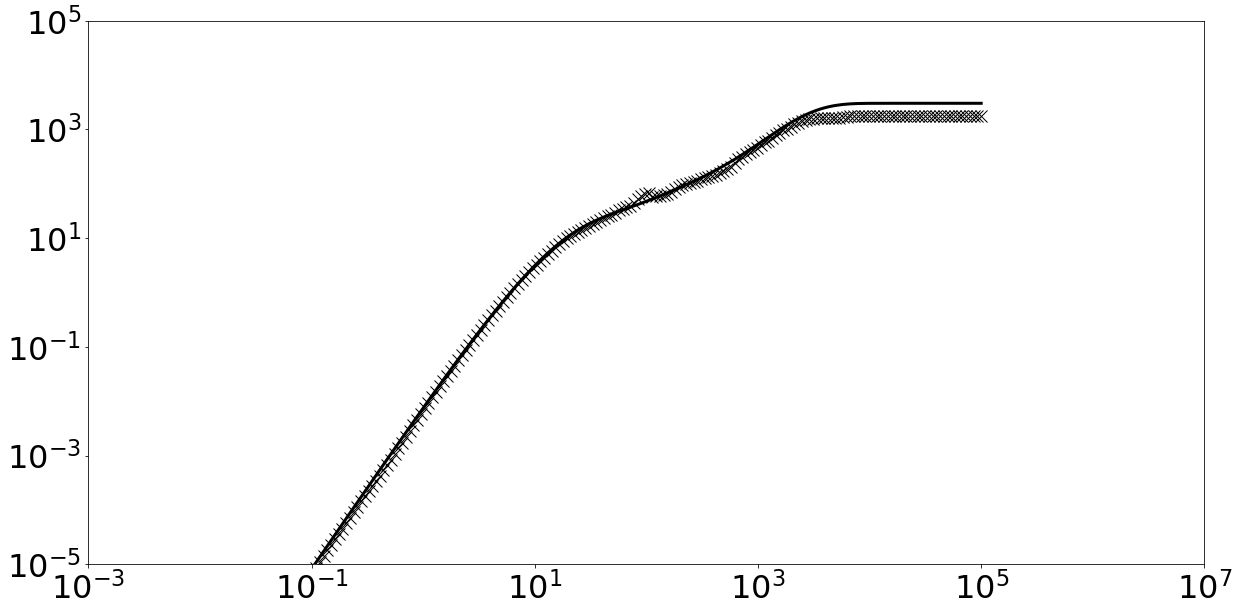

In [120]:
#plt.loglog(T,X.var(0),'x',color='red')
plt.loglog(t,var,'x',color='black',markersize=12)
plt.loglog(t,cumulants(t,2,k1,k2,kap,v),color='black',lw=3)

plt.ylim(1e-5,1e5)
plt.xlim(1e-3,1e7)

In [82]:
# compute variance
var = X.var(0)
# resample and plot points with geometric spacing
tmin = 1e-1 # smallest time to account for
tmax = T.max() # largest 
nperorder = 40 # number of points to keep per order of magnitude 
ts = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of sampling times
digits = np.digitize(T, ts) # indices of T into the bins of ts
#if len(digits)>=len(var):
#    digits=digits[:-1]
var_ds = [var[digits==j].mean() for j in range(0,len(ts))] # downsampled variance

(0.001, 100000.0)

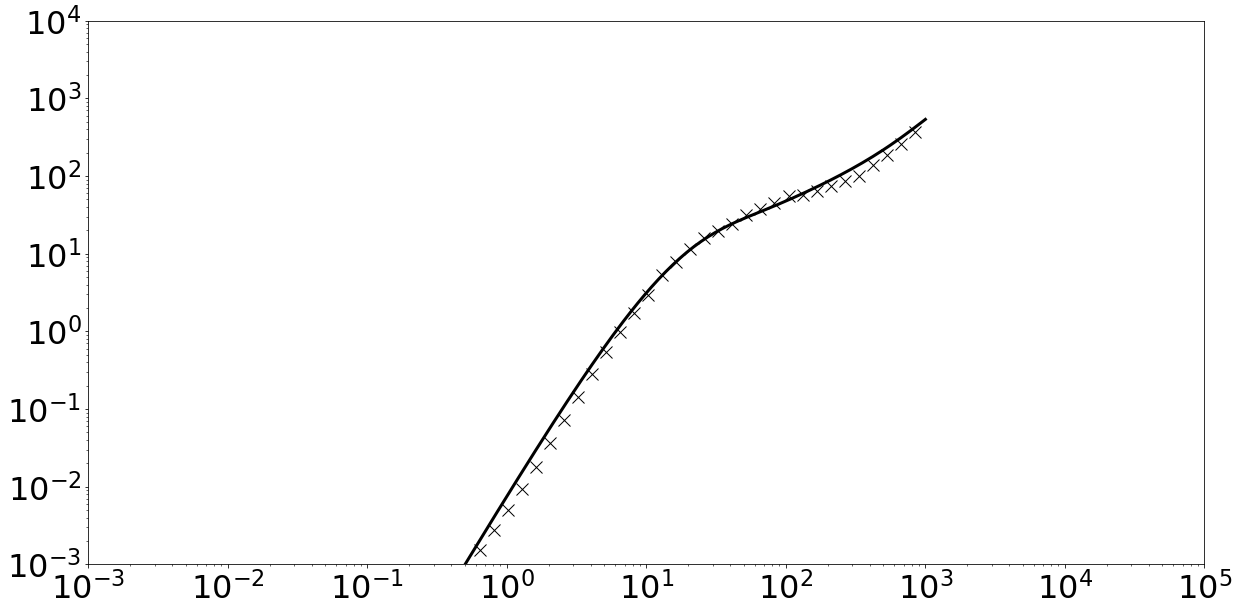

In [84]:
#plt.loglog(T[:-1],var,'o',color='black')
plt.loglog(ts[::4],var_ds[::4],'x',color='black',markersize=12)
plt.loglog(ts,cumulants(ts,2,k1,k2,kap,v),color='black',lw=3)

plt.ylim(1e-3,1e4)
plt.xlim(1e-3,1e5)

In [ ]:
np.save('../simul/Xdat',X)

In [ ]:
tm = 1
tr = 10
tt = 100000
k1 = 1/tr
k2 = 1/tm
kap = 1/tt
v=0.1
t = np.geomspace(1e-3,1e7,100)
plt.loglog(t,cumulants(t,2,k1,k2,kap,v),color='blue',lw=2)#,marker='x',linestyle='None')
plt.ylim(1e-8,1e8)
plt.xlim(1e-3,1e7)

# k1/(k1+k2) is fraction of time spent in motion
# k2/(k1+k2) is fraction of time spent at rest

# crossover from 1st ballistic regime
time1 = 1/np.sqrt(k1*k2)
plt.axvline(time1,color='black')

# crossover zone from 2nd ballistic regime
tau1 = 1/kap
tau2 = 1/(k1*kap/(k1+k2))
time3 = np.sqrt(tau1*tau2)
plt.axvline(time3,color='black')
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma_x^2(t)$',rotation=0,fontsize=12)

# crossover zone into 2nd ballistic regime
#plt.axvline(np.sqrt(1/kap/k2))
#plt.axvline(np.sqrt(1/kap*1/(k1*kap/(k1+k2))))

# mix the lower two times... 
time2 = (1/k1*tau2)**(1/2)
plt.axvline(time2,color='black')

fig = plt.gcf()
fig.set_figheight(7/1.6)
fig.set_figwidth(7)
fig.savefig('../grl/figures/diffusion.png', bbox_inches='tight',dpi=600)

In [ ]:

val = 1e-2
# local range
t0 = np.geomspace(1e-2,time1,100)
plt.loglog(t0,t0**3*val,linestyle='-.',color='black')
val = (t0**3*val).max()
# intermediate range
t1 = np.geomspace(time1,time2,100)
plt.loglog(t1,t1/t1.min()*val,linestyle='-.',color='black')
val = (t1/t1.min()*val).max()
# global range
t2 = np.geomspace(time2,time3,100)
plt.loglog(t2,t2**3/(t2**3).min()*val,linestyle='-.',color='black')
# geomorphic range

In [179]:
def walkit_geom(k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5,retT=False):
    """
    kap is the trapping rate from rest
    k1 is the inverse mean resting time
    k2 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta1 is the probability of starting at rest
    theta2 is the probability of starting in motion
    As written, this saves the walk on geometric intervals with 10 points per order of magnitude
    """
    if theta1+theta2!=1.0:
        raise Exception('Initial conditions do not sum to 1.0!')
    s = int(np.random.random() > theta1) + 1 # initial state
    N = int(tmax/dt) # number of iterations
    nperorder = 10
    T = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times
    X = np.empty_like(T) # set of recorded displacements
    t = 0.0 # initial time
    x = 0.0 # initial position
    ns = 0 # saving index
    ts = T[ns] # next saving time
    nr = 0 # random number index
    nrbatch = 5000 # number of random values to generate at once
    R = np.random.random(size=(nrbatch,2)) # generate the first set of random values
    while t+dt<tmax:
        t += dt # update the time 
        r1,r2 = R[nr] # get a pair of randoms
        nr+=1  #update the index into the array of random values
        if s==1: # if walker is in a rest state
            val1 = 1 - np.exp(-k1*dt) > r1 # probability that transition to motion occurs
            val2 = 1 - np.exp(-kap*dt) > r2  # probability that trapping occurs 
            if val1 and not val2: # provided walker does not trap and does transition to motion
                s = 2  # move it to the motion state
            elif val2: # otherwise if walker traps,
                s=0 # move it to the trapped state
                X[ns:]=x # make all future elements of X have position x
                break # stop the simulation
        elif s==2: # if walker is in a motion state
            x = x + v*dt # walker moves a distance v*dt
            if np.exp(-k2*dt)<r1: # if walker transitions to a rest state
                s = 1   # assign it to rest 
        ### SAVE THE STATE OF THE WALK
        if t>=ts: # if t surpassed the save time
            X[ns] = x # save the value of x 
            ns+=1 # increment the saving index
            ts=T[ns] # find the next time saving happens       
        ### GENERATE MORE RANDOMS WHEN NECESSARY
        if nr==nrbatch-1:
            nr = 0 
            R = np.random.random(size=(nrbatch,2))
    if retT:
        return T,X
    else:
        return X

def ens_geom(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-5,tmax=100,theta1=0.5,theta2=0.5):
    """ do an ensemble of Nens (number) simulations 
    rows (first index) of X are individual simulations
    use geometrically spaced sampling intervals"""
    nperorder=10.0
    T = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times    
    X = np.empty((Nens,T.size))
    for n in range(Nens):
        x = walkit_geom(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta1=theta1,theta2=theta2)
        X[n,:]=x
        clear_output(wait=True)
        print('sample {} of {}'.format(int(n+1),int(Nens)))
    return T,X

def ens_geom_mp(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-5,tmax=100,theta1=0.5,theta2=0.5):
    """ do an ensemble of Nens (number) simulations 
    rows (first index) of X are individual simulations
    use geometrically spaced sampling intervals
    use multiprocessing"""
    nperorder=10.0
    T = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times    
    #X = np.empty((Nens,T.size))
    X = []
    for n in range(Nens):
        x = walkit_geom(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta1=theta1,theta2=theta2)
        X[n,:]=x
        clear_output(wait=True)
        print('sample {} of {}'.format(int(n+1),int(Nens)))
    return T,X

In [183]:
T,X = ens_geom(Nens=200,k1=k1,k2=k2,kap=kap,tmax=1000000,v=0.5,dt=1e-3,theta1=0.3,theta2=0.7)

sample 200 of 200


(0.01, 10000000.0)

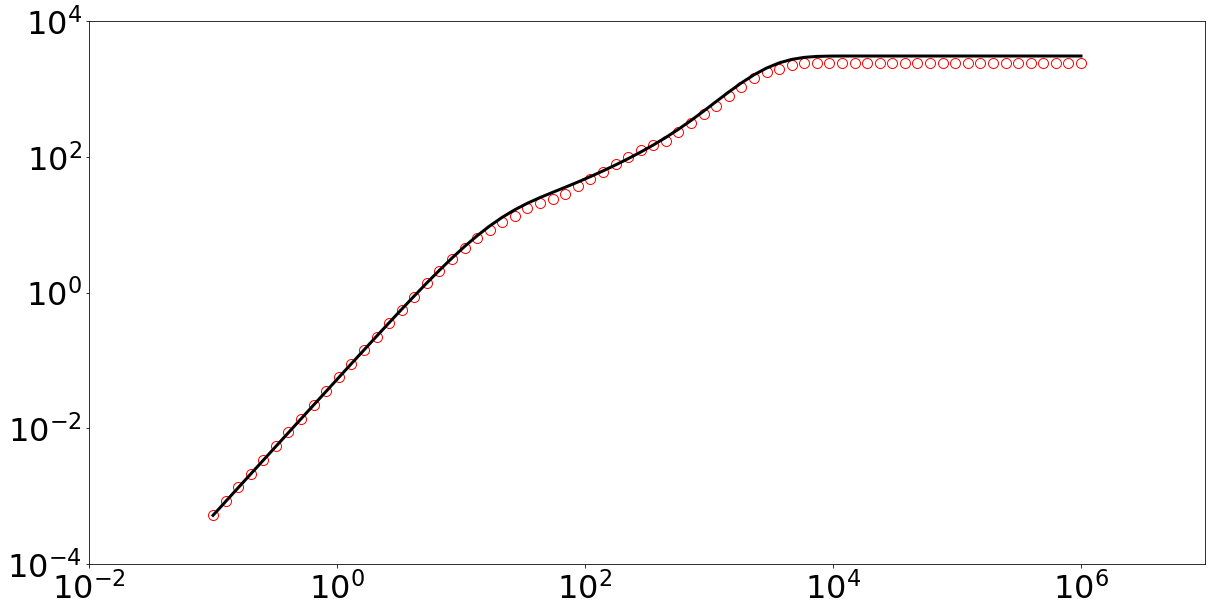

In [222]:
plt.loglog(T,X.var(0),'o',color='red',markersize=10,mfc='none')
plt.loglog(T,cumulantsarb(T,2,k1,k2,kap,v,theta2=0.7),color='black',lw=3)

plt.ylim(1e-4,1e4)
plt.xlim(1e-2,1e7)

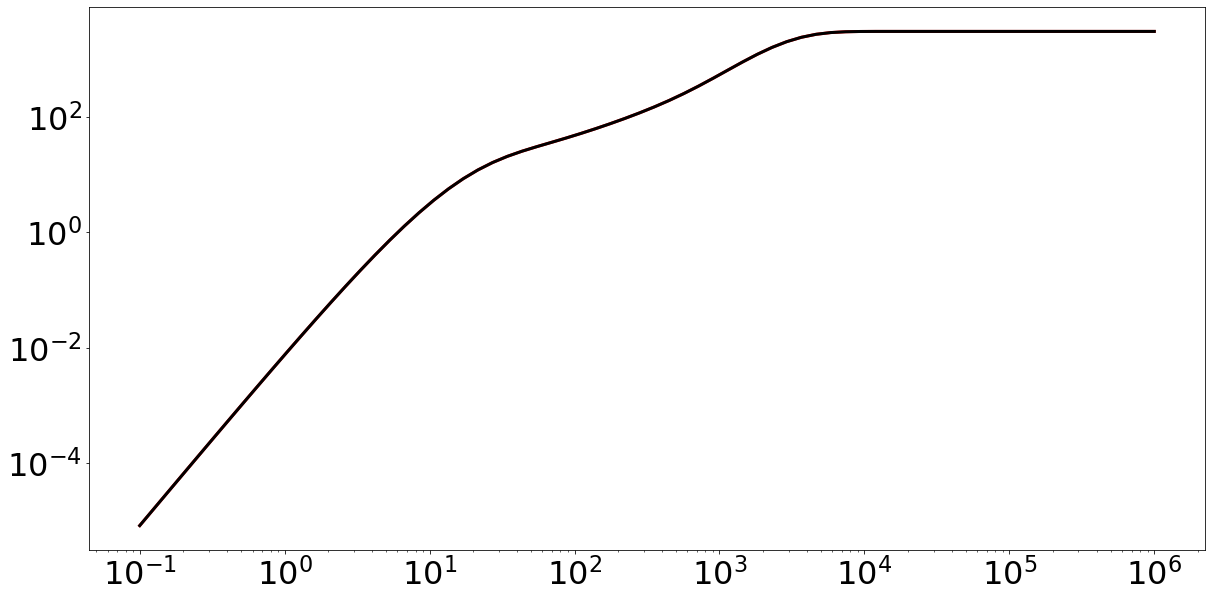

In [203]:
plt.loglog(T,cumulantsarb(T,2,k1,k2,kap,v,theta2=1),color='red',lw=3)
plt.loglog(T,cumulants(T,2,k1,k2,kap,v),color='black',lw=3)
